In [30]:
!pip install geocoder
!pip install folium
import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("All Python Libraries and Dependencies Imported")

     |████████████████████████████████| 102kB 6.7MB/s ta 0:00:011
All Python Libraries and Dependencies Imported


1. Data extraction and cleaning

In [31]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
extracting_data = requests.get(url).text
wiki_data = BeautifulSoup(extracting_data, 'lxml')

In [35]:
column_names = ['Postalcode','Borough','Neighborhood']
toronto = pd.DataFrame(columns = column_names)

content = wiki_data.find('div', class_='mw-parser-output')
table = content.table.tbody
postcode = 0
borough = 0
neighborhood = 0

for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postcode = td.text
            i = i + 1
        elif i == 1:
            borough = td.text
            i = i + 1
        elif i == 2: 
            neighborhood = td.text.strip('\n').replace(']','')
    toronto = toronto.append({'Postalcode': postcode,'Borough': borough,'Neighborhood': neighborhood},ignore_index=True)

In [38]:
toronto = toronto[toronto.Borough!='Not assigned']
toronto = toronto[toronto.Borough!= 0]
toronto.reset_index(drop = True, inplace = True)
i = 0
for i in range(0,toronto.shape[0]):
    if toronto.iloc[i][2] == 'Not assigned':
        toronto.iloc[i][2] = toronto.iloc[i][1]
        i = i+1

In [39]:
df = toronto.groupby(['Postalcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df.head()

,Postalcode,Borough,Neighborhood
0,M1A\n,Not assigned\n,Not assigned\n
1,M1B\n,Scarborough\n,"Malvern, Rouge"
2,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek"
3,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill"
4,M1G\n,Scarborough\n,Woburn


In [40]:
df.describe()

,Postalcode,Borough,Neighborhood
count,180,180,180
unique,180,11,100
top,M7G\n,Not assigned\n,Not assigned\n
freq,1,77,77


In [42]:
df = df.dropna()
empty = 'Not assigned'
df = df[(df.Postalcode != empty ) & (df.Borough != empty) & (df.Neighborhood != empty)]
df.head()

,Postalcode,Borough,Neighborhood
0,M1A\n,Not assigned\n,Not assigned\n
1,M1B\n,Scarborough\n,"Malvern, Rouge"
2,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek"
3,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill"
4,M1G\n,Scarborough\n,Woburn


In [43]:
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['Postalcode', 'Borough'])
df_2 = grp.apply(neighborhood_list).reset_index(name='Neighborhood')

In [46]:
df_2.describe()

,Postalcode,Borough,Neighborhood
count,180,180,180
unique,180,11,100
top,M7G\n,Not assigned\n,Not assigned\n
freq,1,77,77


In [47]:
print(df_2.shape)
df_2.head()

(180, 3)


,Postalcode,Borough,Neighborhood
0,M1A\n,Not assigned\n,Not assigned\n
1,M1B\n,Scarborough\n,"Malvern, Rouge"
2,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek"
3,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill"
4,M1G\n,Scarborough\n,Woburn


In [48]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latilong('M4G')

[43.70909000000006, -79.36409999999995]

In [49]:
postal_codes = df_2['Postalcode']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]

In [50]:
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df_2['Latitude'] = df_coords['Latitude']
df_2['Longitude'] = df_coords['Longitude']
df_2[df_2.Postalcode == 'M5G']

,Postalcode,Borough,Neighborhood,Latitude,Longitude


In [52]:
df_2.head(10)

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1A\n,Not assigned\n,Not assigned\n,43.64869,-79.38544
1,M1B\n,Scarborough\n,"Malvern, Rouge",43.81153,-79.19552
2,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek",43.78564,-79.15871
3,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill",43.76575,-79.17520
4,M1G\n,Scarborough\n,Woburn,43.76820,-79.21761
5,M1H\n,Scarborough\n,Cedarbrae,43.76969,-79.23944
6,M1J\n,Scarborough\n,Scarborough Village,43.74309,-79.23526
7,M1K\n,Scarborough\n,"Kennedy Park, Ionview, East Birchmount Park",43.72861,-79.26367
8,M1L\n,Scarborough\n,"Golden Mile, Clairlea, Oakridge",43.71406,-79.28412
9,M1M\n,Scarborough\n,"Cliffside, Cliffcrest, Scarborough Village West",43.72360,-79.23496


2. Analysis of Etobicoke Neighborhood

In [54]:
address = 'Etobicoke,Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The Geograpical Co-ordinate of Etobicoke, Toronto are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Etobicoke, Toronto are 43.6435559, -79.5656326.


In [56]:
CLIENT_ID = 'Q3EQBANG2QKXUHU4FXS210RRIIW1031TPATT5HISUWGL2L5O'
CLIENT_SECRET = '1ES2VSK2GIWNMILQI2IVUM4EJSZC1HMVJPY1CFS55HIUXYOT'
VERSION = '20190612' # Current date

In [59]:
radius = 800
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_x, 
   longitude_y, 
    radius, 
   LIMIT)
results = requests.get(url).json()
print(results)

{'meta': {'code': 200, 'requestId': '5f189b8aaa50f96509df7430'}, 'response': {'suggestedFilters': {'header': 'Tap to show:', 'filters': [{'name': 'Open now', 'key': 'openNow'}]}, 'headerLocation': 'Etobicoke West Mall', 'headerFullLocation': 'Etobicoke West Mall, Toronto', 'headerLocationGranularity': 'neighborhood', 'totalResults': 16, 'suggestedBounds': {'ne': {'lat': 43.65075590720001, 'lng': -79.5557015702108}, 'sw': {'lat': 43.6363558928, 'lng': -79.5755636297892}}, 'groups': [{'type': 'Recommended Places', 'name': 'recommended', 'items': [{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50d4866ee4b0c1554d94fef7', 'name': 'Tim Hortons', 'location': {'address': '555 Burnhamthorpe Rd', 'crossStreet': 'at The West Mall', 'lat': 43.6447049, 'lng': -79.5676593, 'labeledLatLngs': [{'label': 'display', 'lat': 43.6447049, 'lng': -79.5676593}], 'distance': 207, 'postalCode': 'M9C 2Y3', 'cc

In [60]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['reasons.count', 'reasons.items', 'referralId', 'venue.categories',
       'venue.id', 'venue.location.address', 'venue.location.cc',
       'venue.location.city', 'venue.location.country',
       'venue.location.crossStreet', 'venue.location.distance',
       'venue.location.formattedAddress', 'venue.location.labeledLatLngs',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.neighborhood', 'venue.location.postalCode',
       'venue.location.state', 'venue.name', 'venue.photos.count',
       'venue.photos.groups'],
      dtype='object')

In [61]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

3. Get Nearby Venus and Categories

In [62]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Tim Hortons,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",43.644705,-79.567659
1,Farmer's Market Etobicoke,"[{'id': '4bf58dd8d48988d1fa941735', 'name': 'F...",43.643061,-79.566191
2,Loblaws,"[{'id': '4bf58dd8d48988d118951735', 'name': 'G...",43.643848,-79.560113
3,State & Main Kitchen & Bar,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",43.645778,-79.560374
4,TD Canada Trust,"[{'id': '4bf58dd8d48988d10a951735', 'name': 'B...",43.645502,-79.560006


In [63]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,Tim Hortons,Coffee Shop,43.644705,-79.567659
1,Farmer's Market Etobicoke,Farmers Market,43.643061,-79.566191
2,Loblaws,Grocery Store,43.643848,-79.560113
3,State & Main Kitchen & Bar,Restaurant,43.645778,-79.560374
4,TD Canada Trust,Bank,43.645502,-79.560006


In [64]:
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Clothing Store        1
Recreation Center     1
Café                  1
Skating Rink          1
Restaurant            1
Farmers Market        1
Bank                  1
Mexican Restaurant    1
Grocery Store         1
Coffee Shop           1
Name: categories, dtype: int64

In [71]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [72]:
Etobicoke_venues = getNearbyVenues(names=df_2['Neighborhood'],
                                   latitudes=df_2['Latitude'],
                                   longitudes=df_2['Longitude']
                                  )

Not assigned

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Not assigned

Not assigned

Not assigned

Not assigned

Not assigned

Not assigned

Not assigned

Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Not assigned

Not assigned

Not assigned

Not assigned

Not assigned

Not assigned

Not assigned

Parkwoods
Don Mills
Don Mills
Not assigned

Not assigned

Bathurst Manor, Wilson Heights, Downsview North
No

In [73]:
print('There are {} Uniques Categories.'.format(len(Etobicoke_venues['Venue Category'].unique())))
Etobicoke_venues.groupby('Neighborhood').count().head()

There are 301 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,33,33,33,33,33,33
"Alderwood, Long Branch",7,7,7,7,7,7
"Bathurst Manor, Wilson Heights, Downsview North",4,4,4,4,4,4
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",28,28,28,28,28,28


In [76]:
# one hot encoding
Etobicoke_onehot = pd.get_dummies(Etobicoke_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Etobicoke_onehot['Neighborhood'] = Etobicoke_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Etobicoke_onehot.columns[-1]] + list(Etobicoke_onehot.columns[:-1])
Etobicoke_onehot = Etobicoke_onehot[fixed_columns]
Etobicoke_grouped = Etobicoke_onehot.groupby('Neighborhood').mean().reset_index()
Etobicoke_onehot.head(5)

,Zoo Exhibit,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Paintball Field,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Road,Rock Climbing Spot,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stationery Store,Steakhouse,Storage Facility,Street Art,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / A

In [78]:
num_top_venues = 5
for hood in Etobicoke_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =Etobicoke_grouped[Etobicoke_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Agincourt ----
                 venue  freq
0   Chinese Restaurant  0.09
1        Shopping Mall  0.06
2          Pizza Place  0.06
3  Filipino Restaurant  0.03
4      Badminton Court  0.03


---- Alderwood, Long Branch ----
               venue  freq
0  Convenience Store  0.14
1                Pub  0.14
2        Gas Station  0.14
3                Gym  0.14
4        Coffee Shop  0.14


---- Bathurst Manor, Wilson Heights, Downsview North ----
                  venue  freq
0                  Park  0.50
1  Other Great Outdoors  0.25
2     Convenience Store  0.25
3           Music Venue  0.00
4          Optical Shop  0.00


---- Bayview Village ----
              venue  freq
0           Dog Run  0.25
1             Trail  0.25
2              Park  0.25
3  Asian Restaurant  0.25
4       Zoo Exhibit  0.00


---- Bedford Park, Lawrence Manor East ----
                venue  freq
0          Restaurant  0.07
1         Pizza Place  0.07
2  Italian Restaurant  0.07
3      Sandwich Place  0.07

                 venue  freq
0          Music Store   0.2
1           Hobby Shop   0.2
2    Electronics Store   0.2
3  Arts & Crafts Store   0.2
4               Bakery   0.2


---- Humberlea, Emery ----
                       venue  freq
0                Coffee Shop  0.29
1                  Nightclub  0.14
2  Latin American Restaurant  0.14
3                       Park  0.14
4                       Café  0.14


---- Humewood-Cedarvale ----
           venue  freq
0  Grocery Store  0.22
1  Deli / Bodega  0.11
2          Trail  0.11
3    Coffee Shop  0.11
4   Hockey Arena  0.11


---- India Bazaar, The Beaches West ----
         venue  freq
0   Restaurant  0.09
1  Coffee Shop  0.06
2       Bakery  0.06
3      Brewery  0.06
4         Café  0.06


---- Islington Avenue, Humber Valley Village ----
               venue  freq
0           Pharmacy  0.18
1               Bank  0.09
2       Skating Rink  0.09
3  Convenience Store  0.09
4             Bakery  0.09


---- Kennedy Park, Ionview, East 

                 venue  freq
0          Coffee Shop  0.12
1                Hotel  0.08
2                 Café  0.06
3  Japanese Restaurant  0.03
4             Beer Bar  0.03


---- Studio District ----
         venue  freq
0  Coffee Shop  0.07
1         Café  0.05
2       Bakery  0.05
3        Diner  0.05
4          Bar  0.05


---- Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park ----
          venue  freq
0  Skating Rink  0.10
1           Pub  0.10
2   Coffee Shop  0.10
3   Pizza Place  0.05
4    Restaurant  0.05


---- The Annex, North Midtown, Yorkville ----
                venue  freq
0      Sandwich Place  0.08
1  Italian Restaurant  0.08
2                Park  0.06
3                Café  0.06
4  Mexican Restaurant  0.06


---- The Beaches ----
            venue  freq
0             Bar  0.08
1             Pub  0.08
2           Trail  0.04
3  Sandwich Place  0.04
4     Coffee Shop  0.04


---- The Danforth West, Riverdale ----
                venue  freq
0        

In [88]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

5. Most Common Venue in Etobicoke, Toronto - per neighborhood

In [89]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Etobicoke_grouped['Neighborhood']

for ind in np.arange(Etobicoke_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Etobicoke_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Chinese Restaurant,Pizza Place,Shopping Mall,Seafood Restaurant,Japanese Restaurant,Sushi Restaurant,Supermarket,Latin American Restaurant,Filipino Restaurant,Malay Restaurant
1,"Alderwood, Long Branch",Gas Station,Gym,Pizza Place,Sandwich Place,Convenience Store,Pub,Coffee Shop,Dog Run,Doner Restaurant,Donut Shop
2,"Bathurst Manor, Wilson Heights, Downsview North",Park,Convenience Store,Other Great Outdoors,Yoga Studio,Event Space,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant
3,Bayview Village,Park,Asian Restaurant,Trail,Dog Run,Yoga Studio,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Pizza Place,Coffee Shop,Restaurant,Italian Restaurant,Fast Food Restaurant,Juice Bar,Sushi Restaurant,Sports Club,Liquor Store


6. K-Means Clustering

In [81]:
Etobicoke_grouped_clustering = Etobicoke_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(Etobicoke_grouped_clustering)
kmeans.labels_

array([1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2], dtype=int32)

In [85]:
neighborhoods_venues_sorted.insert(0,'Cluster labels', kmeans.labels_)

Etobicoke_merged =df_2.iloc[:16,:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Etobicoke_merged = Etobicoke_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Etobicoke_merged.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster labels,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1A\n,Not assigned\n,Not assigned\n,43.64869,-79.38544,1,1,Coffee Shop,Hotel,Café,Bookstore,Beer Bar,Japanese Restaurant,Theater,Arts & Crafts Store,Pizza Place,Furniture / Home Store
1,M1B\n,Scarborough\n,"Malvern, Rouge",43.81153,-79.19552,1,1,Zoo Exhibit,Paintball Field,Fast Food Restaurant,Farmers Market,Ethiopian Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
2,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek",43.78564,-79.15871,1,1,Fish & Chips Shop,Bar,Yoga Studio,Farm,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant
3,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill",43.76575,-79.17520,2,2,Park,Athletics & Sports,Gym / Fitness Center,Yoga Studio,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant
4,M1G\n,Scarborough\n,Woburn,43.76820,-79.21761,1,1,Chinese Restaurant,Fast Food Restaurant,Park,Coffee Shop,Yoga Studio,Event Space,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store


In [90]:
kclusters = 10

In [92]:
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(Etobicoke_merged['Latitude'], 
                                   Etobicoke_merged['Longitude'], 
                                   Etobicoke_merged['Neighborhood'], 
                                   Etobicoke_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


In [135]:
df1=Etobicoke_merged.loc[Etobicoke_merged['Cluster Labels'] == 0,Etobicoke_merged.columns[[2] + list(range(5, Etobicoke_merged.shape[1]))]]
df2=Etobicoke_merged.loc[Etobicoke_merged['Cluster Labels'] == 1,Etobicoke_merged.columns[[2] + list(range(5, Etobicoke_merged.shape[1]))]]
df3=Etobicoke_merged.loc[Etobicoke_merged['Cluster Labels'] == 2,Etobicoke_merged.columns[[2] + list(range(5, Etobicoke_merged.shape[1]))]]

In [136]:

clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster4":df3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)


In [144]:
new_Etobicoke=Etobicoke_merged.set_index("Neighborhood",drop=True)
#Source:https://www.greatschools.org
Etobicoke_school_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9,2,6,4,7,5,10,4,6,8,9,7,5,6,5,8,7, 5, 6, 10, 4, 6, 7, 9, 5, 6, 7, 1, 4, 3, 1,
                                                           3,2,4,10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9,2,6,4,7,5,10,4,
                                                           ]})

In [145]:
Etobicoke_school_ratings.set_index('Neighborhood',inplace=True,drop=True)

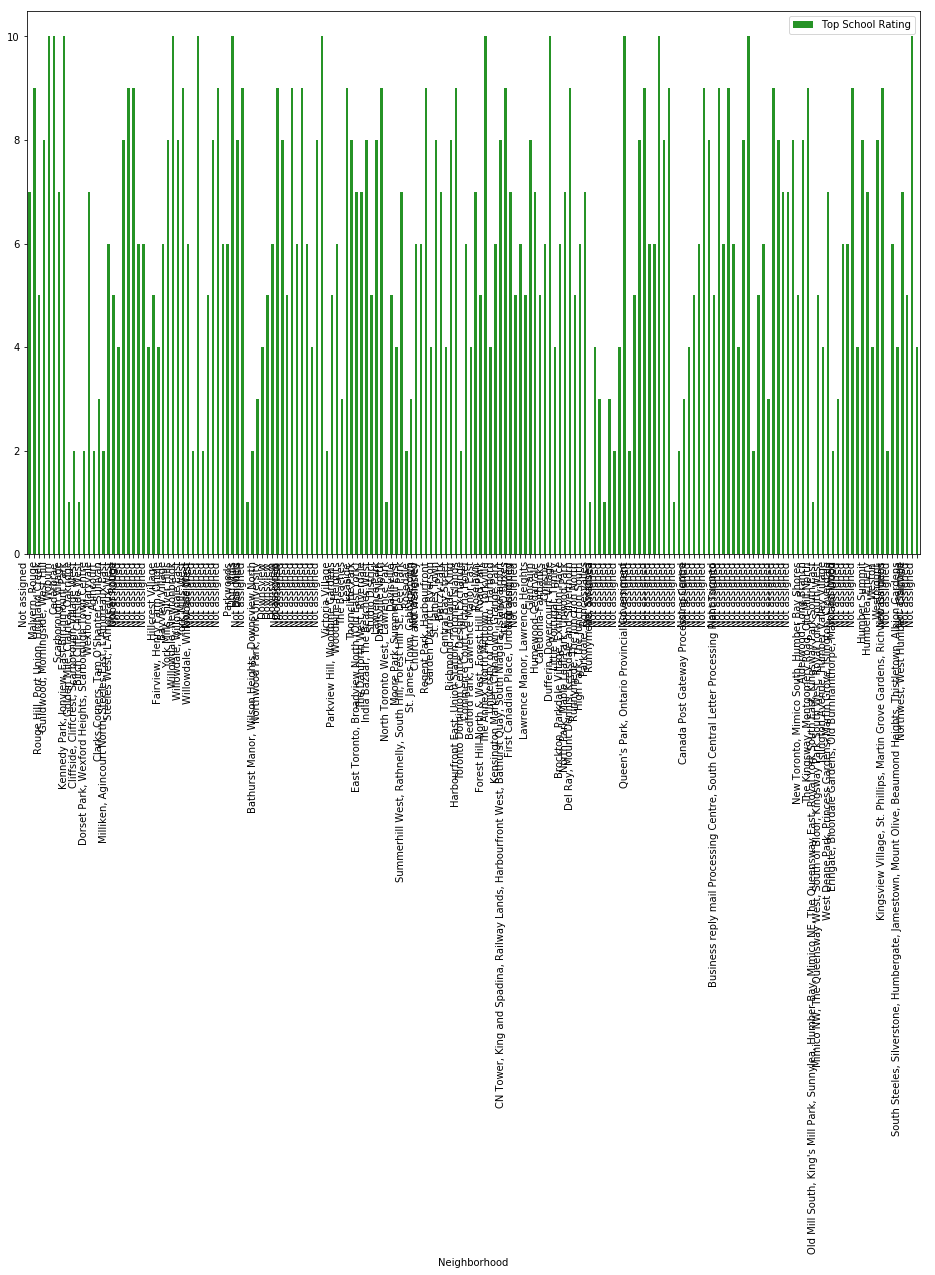

In [143]:
Etobicoke_school_ratings.plot(kind='bar',figsize=(16,10),color='green',alpha=0.85);

In [152]:
Etobicoke_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df_2["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                                               279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0,
                                                               279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,
                                                               289000.0,370500.,255400.0,413500.0,433500.0,254800.0,
                                                               289000.0,370500.,255400.0,413500.0,433500.0,254800.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,433500.0,
                                                               195000.0,370500.,255400.0,403500.0,433500.0,285900.0,
                                                            229200.0,365000.0,388500.,285400.0,493500.0,477500.0,316600.0,195000.0,225900.0,219400.0,
                                                              ]})

In [153]:
Etobicoke_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)

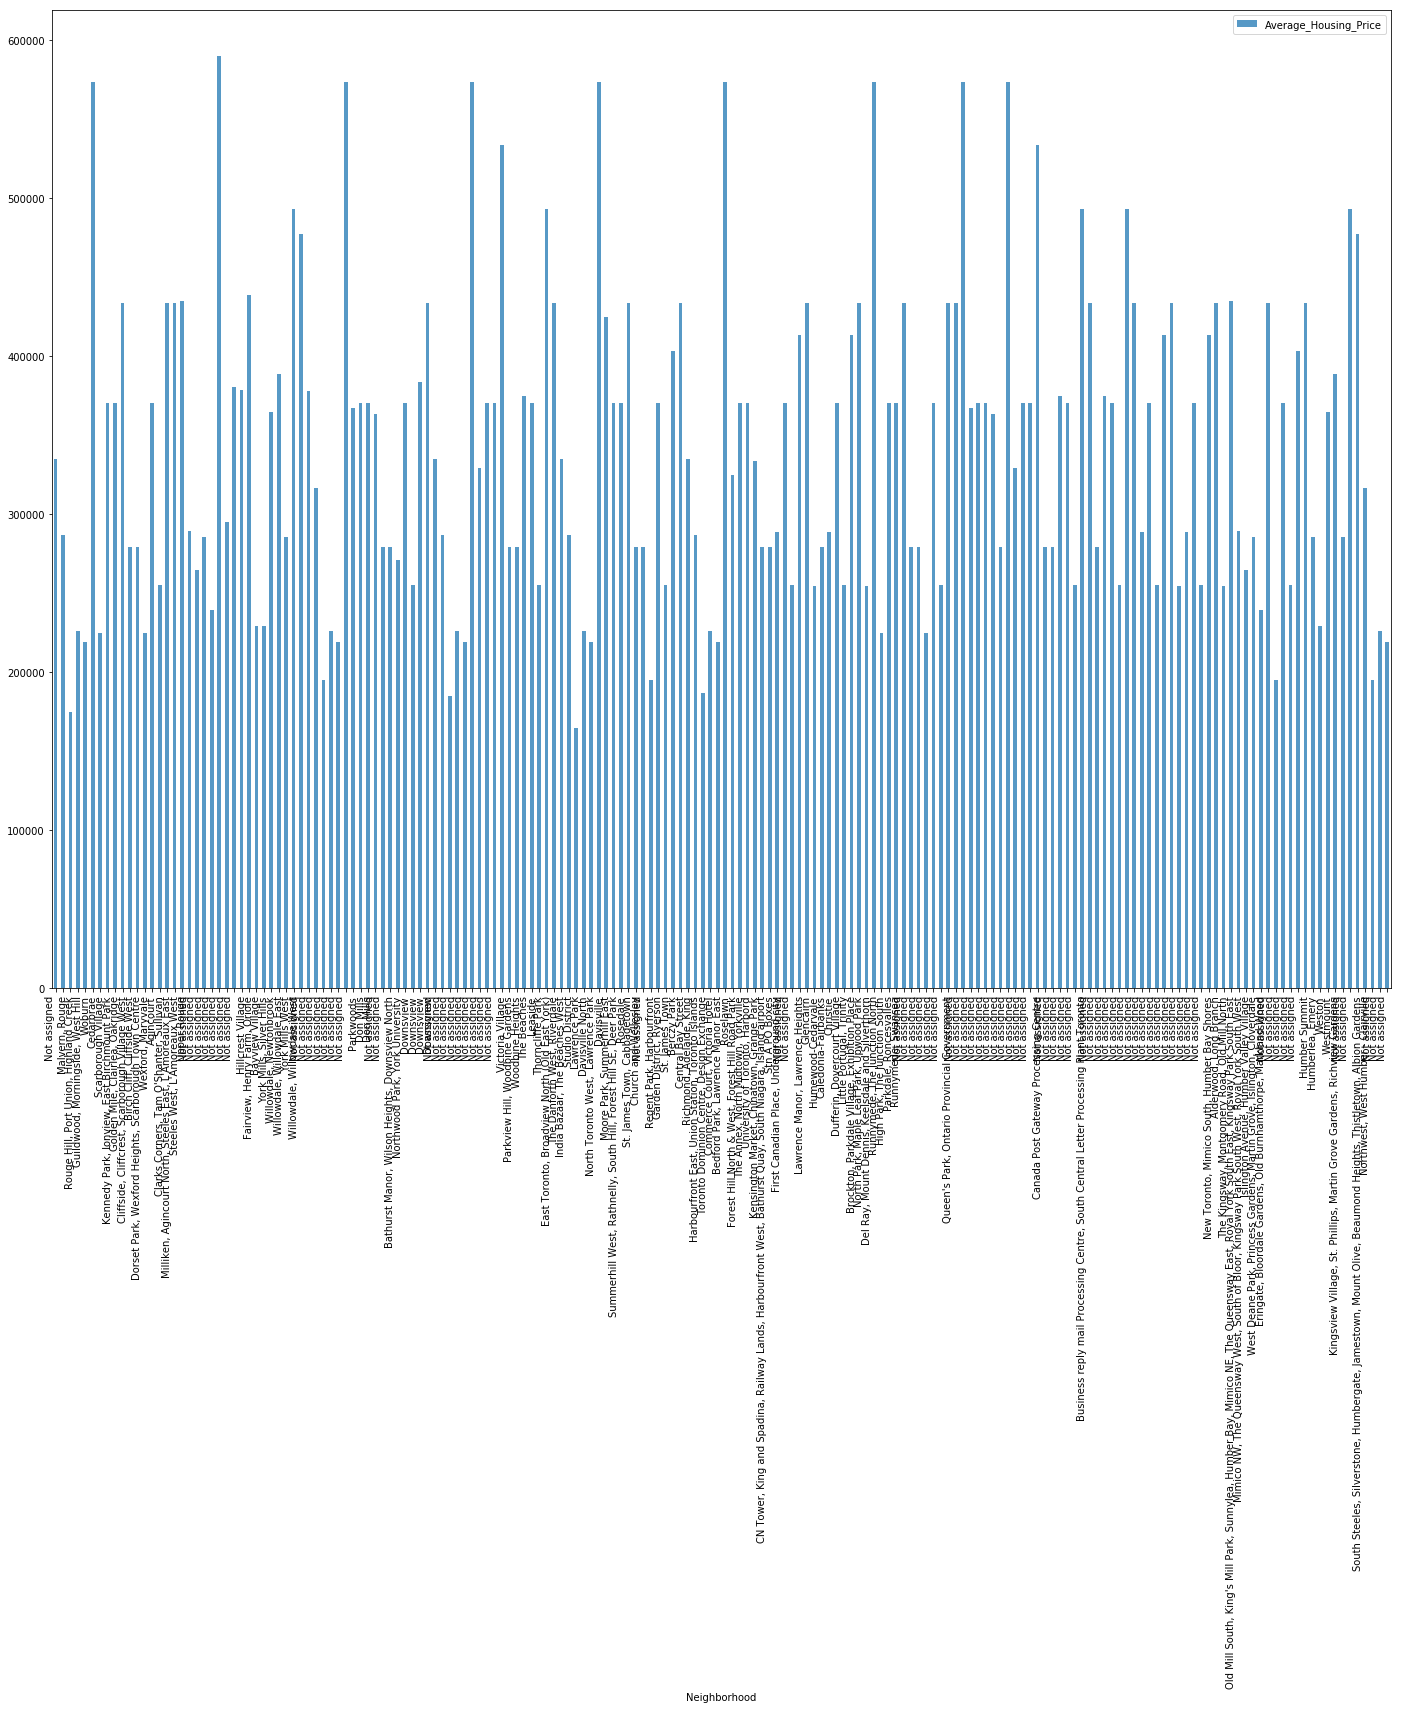

In [154]:
Etobicoke_Avg_HousingPrice.plot(kind='bar',figsize=(24,18),alpha=0.75)